# Notebook 11_Multimodal Model

## ✅ Step 1: Load & Preprocess Data

In [12]:
import pandas as pd
import numpy as np

# Load energy data
energy_df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
energy_df.set_index('utc_timestamp', inplace=True)

# Load sentiment data
sentiment_df = pd.read_csv('../data/processed/filtered_energy_news_with_sentiment.csv', parse_dates=['date'])
sentiment_df.rename(columns={'date': 'utc_timestamp'}, inplace=True)
sentiment_df['utc_timestamp'] = sentiment_df['utc_timestamp'].dt.floor('H')  # Round to nearest hour
sentiment_df.set_index('utc_timestamp', inplace=True)

# Keep only numeric columns
numeric_sentiment = sentiment_df.select_dtypes(include='number')

# Resample to hourly (mean) and forward-fill
sentiment_hourly = numeric_sentiment.resample('H').mean().ffill()

C:\Users\iTECH\AppData\Local\Temp\ipykernel_12160\381678344.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sentiment_df['utc_timestamp'] = sentiment_df['utc_timestamp'].dt.floor('H')  # Round to nearest hour
C:\Users\iTECH\AppData\Local\Temp\ipykernel_12160\381678344.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sentiment_hourly = numeric_sentiment.resample('H').mean().ffill()


## ✅ Step 2: Merge & Clean

In [13]:
# Merge on timestamp
merged_df = energy_df.merge(sentiment_hourly, left_index=True, right_index=True, how='left')

# Drop if target missing
merged_df = merged_df.dropna(subset=['Price (EUR/MWhe)'])


## ✅ Step 3: Feature Engineering

In [14]:
from sklearn.model_selection import train_test_split

# Check which sentiment features were merged successfully
sentiment_features = [col for col in merged_df.columns if col in ['avg_score', 'pos_ratio']]
base_features = [
    'DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency',
    'Gas_Price', 'Oil_Price', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
    'DE_temperature',
    'price_lag_1h', 'price_lag_24h', 'price_lag_168h',
    'price_roll_24h', 'price_roll_168h',
    'hour', 'dayofweek', 'month',
    'solar_load_ratio', 'wind_load_ratio'
]
features = base_features + sentiment_features

# Add lag and rolling features
merged_df['price_lag_1h'] = merged_df['Price (EUR/MWhe)'].shift(1)
merged_df['price_lag_24h'] = merged_df['Price (EUR/MWhe)'].shift(24)
merged_df['price_lag_168h'] = merged_df['Price (EUR/MWhe)'].shift(168)
merged_df['price_roll_24h'] = merged_df['Price (EUR/MWhe)'].rolling(24).mean()
merged_df['price_roll_168h'] = merged_df['Price (EUR/MWhe)'].rolling(168).mean()

# Calendar and ratio features
merged_df['hour'] = merged_df.index.hour
merged_df['dayofweek'] = merged_df.index.dayofweek
merged_df['month'] = merged_df.index.month
merged_df['solar_load_ratio'] = merged_df['DE_solar_generation_actual'] / merged_df['DE_load_actual_entsoe_transparency']
merged_df['wind_load_ratio'] = merged_df['DE_wind_generation_actual'] / merged_df['DE_load_actual_entsoe_transparency']

# Final dataframe
final_df = merged_df[features + ['Price (EUR/MWhe)']].dropna()

# Train-test split
X = final_df[features]
y = final_df['Price (EUR/MWhe)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## ✅ Step 4: Split & Train Model

MAE: 2.30, RMSE: 3.67


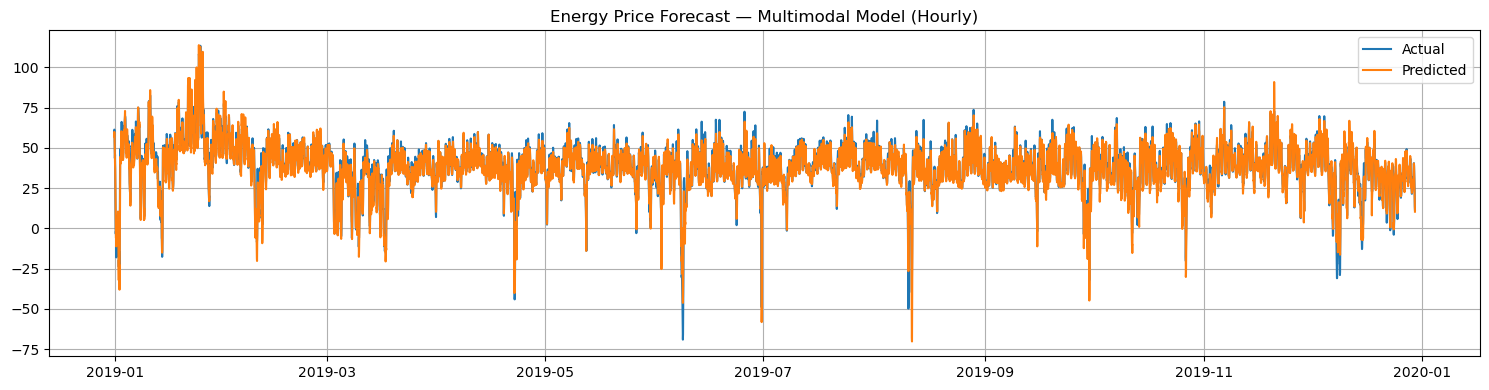

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Train the model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # no squared=False

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(15, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Energy Price Forecast — Multimodal Model (Hourly)')
plt.grid(True)
plt.tight_layout()
plt.show()